# Time Series Regime Analysis

This notebook explores time series regime analysis in python. Markov Switching Autoregressions (MS-AR) are used to detect and classify underlying states. A Random Forest Classifier is used to predict the next regime.

In [3]:
# getting the latest version of scikit-learn for under_sampling
!pip uninstall scikit-learn -y

Found existing installation: scikit-learn 0.24.2
Uninstalling scikit-learn-0.24.2:


ERROR: Exception:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\shutil.py", line 814, in move
    os.rename(src, real_dst)
PermissionError: [WinError 5] Access is denied: 'c:\\programdata\\anaconda3\\lib\\site-packages\\scikit_learn-0.24.2.dist-info\\' -> 'C:\\ProgramData\\Anaconda3\\Lib\\site-packages\\~1ikit_learn-0.24.2.dist-info'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\pip\_internal\cli\base_command.py", line 173, in _main
    status = self.run(options, args)
  File "C:\ProgramData\Anaconda3\lib\site-packages\pip\_internal\commands\uninstall.py", line 93, in run
    uninstall_pathset = req.uninstall(
  File "C:\ProgramData\Anaconda3\lib\site-packages\pip\_internal\req\req_install.py", line 633, in uninstall
    uninstalled_pathset.remove(auto_confirm, verbose)
  File "C:\ProgramData\Anaconda3\lib\site-packages\pip\_internal\req\req_uninstall.

In [4]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yfinance as yf
import pandas as pd
import random

import numpy as np
import scipy.stats as scs

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from collections import Counter, deque
from imblearn.under_sampling import RandomUnderSampler

## MS-AR

Importing our S&P 500 dataset from Yahoo Finance, using the yfinance library. Displaying the data in a dataframe.

In [5]:
df = yf.download('^GSPC', start="2000-01-01", end="2022-09-01", interval="1d")
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-12-31,1464.469971,1472.420044,1458.189941,1469.250000,1469.250000,374050000
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000


----------------------------------------------------------------
Plotting the adjusted close price to visualize the time series.

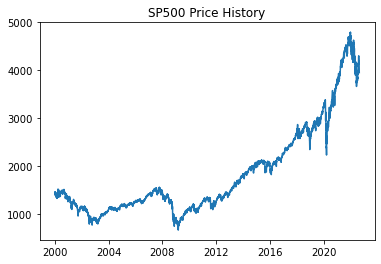

In [6]:
plt.title(f'SP500 Price History')
plt.plot(
    list(i for i in df.index),
    list(i[4] for i in df.values))
plt.grid(False)

------------------------
Creating and plotting price returns. Price returns are just the percentage change in price over 1 day.

<AxesSubplot:title={'center':'Excess returns'}, xlabel='Date'>

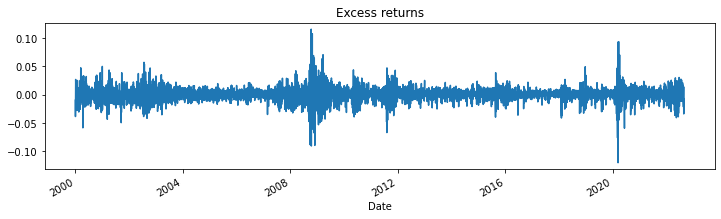

In [8]:
df['r-1'] = df['Adj Close'].pct_change().dropna()

ex_ret = df['r-1']
ex_ret.plot(title='Excess returns', figsize=(12, 3), grid=False)

---------------------
Fitting the Markov regression model and viewing a summary output.

In [10]:
# Fit the model
mod_kns = sm.tsa.MarkovRegression(ex_ret.dropna(), k_regimes=2, trend='n', switching_variance=True)
res_kns = mod_kns.fit()
res_kns.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                    r-1   No. Observations:                 5703
Model:               MarkovRegression   Log Likelihood               18113.347
Date:                Thu, 13 Oct 2022   AIC                         -36218.694
Time:                        08:42:01   BIC                         -36192.099
Sample:                             0   HQIC                        -36209.435
                               - 5703                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.912e-05   1.62e-06     30.292      0.000    4.59e-05    5.23e-05
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0004   1.59e-05     24.197      0.000       0.000       0.000
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9886      0.002    443.917      0.000       0.984       0.993
p[1->0]        0.0240      0.005      4.929      0.000       0.014       0.033
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

-----------------
Viewing the smoothed probabilistic outputs from the fitted model. These are the models regime classifications on the dataset fitted. These probabilities are then plotted.

In [11]:
res_kns.smoothed_marginal_probabilities.head()

,0,1
Date,,
2000-01-03,0.029665,0.970335
2000-01-04,0.000002,0.999998
2000-01-05,0.003385,0.996615
2000-01-06,0.003566,0.996434
2000-01-07,0.000665,0.999335


In [12]:
print(res_kns.smoothed_marginal_probabilities.head())

                   0         1
Date                          
2000-01-03  0.029665  0.970335
2000-01-04  0.000002  0.999998
2000-01-05  0.003385  0.996615
2000-01-06  0.003566  0.996434
2000-01-07  0.000665  0.999335


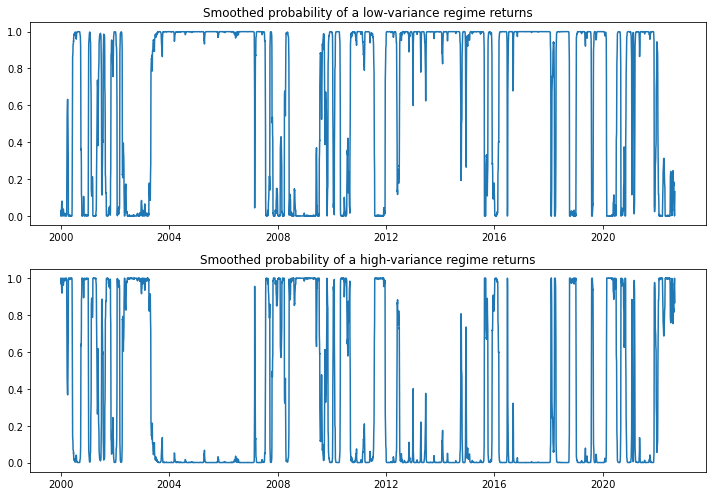

In [13]:
fig, axes = plt.subplots(2, figsize=(10,7))
ax = axes[0]
ax.plot(res_kns.smoothed_marginal_probabilities[0])
ax.grid(False)
ax.set(title='Smoothed probability of a low-variance regime returns')
ax = axes[1]
ax.plot(res_kns.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of a high-variance regime returns')
fig.tight_layout()
ax.grid(False)

----------
Encoding regimes into binary states. 

0 --> low variance regime returns

1 --> high variance regime returns

In [14]:
low_var = list(res_kns.smoothed_marginal_probabilities[0])
high_var = list(res_kns.smoothed_marginal_probabilities[1])

regime_list = []
for i in range(0, len(low_var)):
    if low_var[i] > high_var[i]:
        regime_list.append(0)
    else:
        regime_list.append(1)

In [15]:
regime_df = pd.DataFrame()
regime_df['regimes'] = regime_list

------
Plotting the encoded states on the adjusted close price series of the S&P 500, this gives a visual representation of the models regime classifications in time and price space.

Text(0.5, 0.98, 'Historical SP500 regimes')

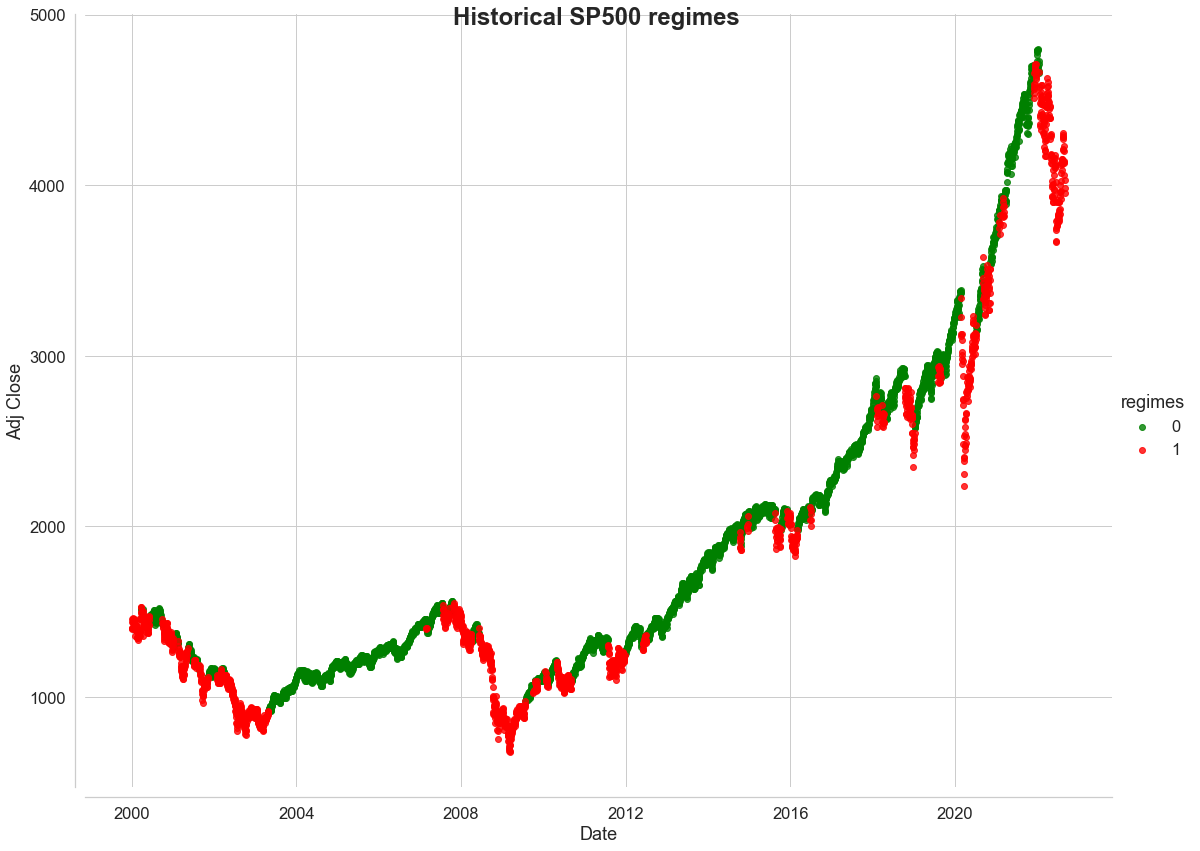

In [18]:
sns.set(font_scale=1.5)
df = df.iloc[len(df)-len(regime_list):]
regimes = (pd.DataFrame(regime_list, columns=['regimes'], index=df.index)
          .join(df, how='inner')
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))
regimes.head()

import warnings
warnings.filterwarnings("ignore")
colors = 'green', 'red', 'yellow'
sns.set_style("whitegrid")
order = [0, 1]
fg = sns.FacetGrid(data=regimes, hue='regimes', hue_order=order,
                   palette=colors, aspect=1.31, height=12)
fg.map(plt.scatter, 'Date', "Adj Close", alpha=0.8).add_legend()
sns.despine(offset=10)
fg.fig.suptitle('Historical SP500 regimes', fontsize=24, fontweight='demi')

## Machine learning

Loading the dataset and creating features for the random forest classifier.

In [19]:
ml_df = yf.download('^GSPC', start="2000-01-01", end="2022-09-01", interval="1d")

# price and volume returns
for i in [1, 2, 3, 5, 7, 14, 21]:
    ml_df[f'Close_{i}_Value'] = ml_df['Adj Close'].pct_change(i)
    ml_df[f'Volume_{i}_Value'] = ml_df['Volume'].pct_change(i)
ml_df.dropna(inplace=True)

# probabilities
low_var_prob = list(res_kns.smoothed_marginal_probabilities[0])
high_var_prob = list(res_kns.smoothed_marginal_probabilities[1])
ml_df['Low_Var_Prob'] = low_var_prob[len(low_var_prob)-len(ml_df):] # adjust length
ml_df['High_Var_Prob'] = high_var_prob[len(high_var_prob)-len(ml_df):]

# volatility     
for i in [3, 7, 14, 21]:
    ml_df[f'Volt_{i}_Value'] = np.log(1 + ml_df['Close_1_Value']).rolling(i).std()
    
ml_df.dropna(inplace=True)

# states
ml_df['regimes'] = regime_list[len(regimes)-len(ml_df):] # adjust length

ml_df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Close_1_Value,Volume_1_Value,Close_2_Value,Volume_2_Value,...,Volume_14_Value,Close_21_Value,Volume_21_Value,Low_Var_Prob,High_Var_Prob,Volt_3_Value,Volt_7_Value,Volt_14_Value,Volt_21_Value,regimes
Date,,,,,,,,,,,,,,,,,,,,,
2000-03-01,1366.420044,1383.459961,1366.420044,1379.189941,1379.189941,1274100000,0.009346,0.057959,0.023100,0.241208,...,0.212851,-0.010950,0.282049,0.008880,0.991120,0.002133,0.010141,0.013191,0.012497,1
2000-03-02,1379.189941,1386.560059,1370.349976,1381.760010,1381.760010,1198600000,0.001863,-0.059258,0.011226,-0.004733,...,0.132036,-0.019528,0.221814,0.007620,0.992380,0.005910,0.010145,0.013146,0.012253,1
2000-03-03,1381.760010,1410.880005,1381.760010,1409.170044,1409.170044,1150300000,0.019837,-0.040297,0.021737,-0.097167,...,0.121478,0.000036,0.107549,0.001010,0.998990,0.008930,0.011943,0.013039,0.013052,1
2000-03-06,1409.170044,1409.739990,1384.750000,1391.280029,1391.280029,1029000000,-0.012695,-0.105451,0.006890,-0.141498,...,0.109673,-0.023643,-0.102486,0.000609,0.999391,0.016235,0.013272,0.013551,0.013072,1
2000-03-07,1391.280029,1399.209961,1349.989990,1355.619995,1355.619995,1314100000,-0.025631,0.277065,-0.038001,0.142398,...,0.203278,-0.048267,0.257392,0.000019,0.999981,0.023470,0.016214,0.014949,0.014147,1


------
Creating the data labels by shifting the current state back by one day. This brings the next days state into the current day, creating a future target state for the model to map to and predict.

In [20]:
ml_df['regimes'] = ml_df['regimes'].shift(-1) 
ml_df.dropna(inplace=True)
ml_df

,Open,High,Low,Close,Adj Close,Volume,Close_1_Value,Volume_1_Value,Close_2_Value,Volume_2_Value,...,Volume_14_Value,Close_21_Value,Volume_21_Value,Low_Var_Prob,High_Var_Prob,Volt_3_Value,Volt_7_Value,Volt_14_Value,Volt_21_Value,regimes
Date,,,,,,,,,,,,,,,,,,,,,
2000-03-01,1366.420044,1383.459961,1366.420044,1379.189941,1379.189941,1274100000,0.009346,0.057959,0.023100,0.241208,...,0.212851,-0.010950,0.282049,0.008880,0.991120,0.002133,0.010141,0.013191,0.012497,1.0
2000-03-02,1379.189941,1386.560059,1370.349976,1381.760010,1381.760010,1198600000,0.001863,-0.059258,0.011226,-0.004733,...,0.132036,-0.019528,0.221814,0.007620,0.992380,0.005910,0.010145,0.013146,0.012253,1.0
2000-03-03,1381.760010,1410.880005,1381.760010,1409.170044,1409.170044,1150300000,0.019837,-0.040297,0.021737,-0.097167,...,0.121478,0.000036,0.107549,0.001010,0.998990,0.008930,0.011943,0.013039,0.013052,1.0
2000-03-06,1409.170044,1409.739990,1384.750000,1391.280029,1391.280029,1029000000,-0.012695,-0.105451,0.006890,-0.141498,...,0.109673,-0.023643,-0.102486,0.000609,0.999391,0.016235,0.013272,0.013551,0.013072,1.0
2000-03-07,1391.280029,1399.209961,1349.989990,1355.619995,1355.619995,1314100000,-0.025631,0.277065,-0.038001,0.142398,...,0.203278,-0.048267,0.257392,0.000019,0.999981,0.023470,0.016214,0.014949,0.014147,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-24,4126.549805,4156.560059,4119.970215,4140.770020,4140.770020,3056910000,0.002916,-0.019530,0.000672,-0.091617,...,-0.142717,0.056036,-0.008598,0.027833,0.972167,0.012942,0.009266,0.010699,0.011516,1.0
2022-08-25,4153.259766,4200.540039,4147.589844,4199.120117,4199.120117,2976050000,0.014092,-0.026452,0.017049,-0.045465,...,-0.159370,0.043620,-0.169668,0.009408,0.990592,0.008295,0.011654,0.011334,0.010574,1.0
2022-08-26,4198.740234,4203.040039,4057.659912,4057.659912,4057.659912,3175260000,-0.033688,0.066938,-0.020071,0.038716,...,-0.119121,-0.003627,-0.182235,0.000259,0.999741,0.025280,0.016531,0.014744,0.012945,1.0


In [21]:
rf_df = ml_df.copy()
labels = rf_df.pop('regimes') # get target states into a variable
labels = labels.astype('int')

-----
Splitting the dataset into training and testing. Rebalancing the dataset by undersampling the smallest prediction category which is the low variance regime return.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(rf_df, labels, test_size=0.2)
Counter(y_train)

Counter({0: 3111, 1: 1418})

In [23]:
# undersample our low_variance regime examples
under_sampler = RandomUnderSampler(random_state=40)
X_rs, y_rs = under_sampler.fit_resample(X_train, y_train)

In [24]:
Counter(y_rs)

Counter({0: 1418, 1: 1418})

------
Initializing and fitting the random forest classifier with 20 trees in the forest.

In [25]:
rf = RandomForestClassifier(n_estimators=20)
rf.fit(X_rs, y_rs)

RandomForestClassifier(n_estimators=20)

-----
Making predictions on the testing dataset. Two predictions are retrieved, the binary predicted state and the probabilistic state prediction.

In [26]:
y_pred = rf.predict(X_test)
y_prob_pred = rf.predict_proba(X_test)

-----
Assessing the models accuracy using an accuracy score, area under curve, false positive rate and true positive rate.

In [27]:
acc_score = accuracy_score(y_test, y_pred)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('accuracy_score=', acc_score,'roc_auc=', roc_auc, 'FPR=', false_positive_rate[1],  'TPR=', true_positive_rate[1])

accuracy_score= 0.9911738746690203 roc_auc= 0.9912442984856779 FPR= 0.008939974457215836 TPR= 0.9914285714285714


--------
Checking the impact of different size random forests on model accuracy to determine the optimal number of forests to initialize the classifier with.

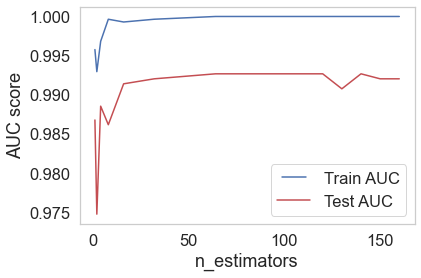

In [28]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 110, 120, 130, 140, 150, 160]
train_results = []
test_results = []

for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator)
    rf.fit(X_rs, y_rs)
    train_pred = rf.predict(X_rs)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_rs, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, "b", label="Train AUC")
line2, = plt.plot(n_estimators, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.grid(False)
plt.show()

------
Analyzing the permutation importance of the features provided to the model.

In [29]:
rf = RandomForestClassifier(n_estimators=20)
rf.fit(X_rs, y_rs)

RandomForestClassifier(n_estimators=20)

In [30]:
results = permutation_importance(rf, X_rs, y_rs, scoring='accuracy')

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00007
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.31664
Feature: 21, Score: 0.30705
Feature: 22, Score: 0.00085
Feature: 23, Score: 0.00113
Feature: 24, Score: 0.00056
Feature: 25, Score: 0.00092


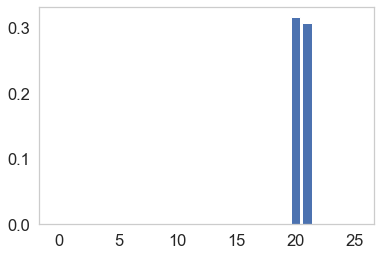

In [31]:
importance = results.importances_mean

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(importance))], importance)
plt.grid(False)
plt.show()

In [31]:
ml_df.columns[25]

'Volt_21_Value'